In [94]:
# Libraries and data setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle

THRESHOLD = 0.55

colors = {
    'precision': '#59A14F',
    'recall':    '#F28E2B',
    'f1_score':  '#4682B4',
    'parameter_efficiency':  '#4682B4',
    'time_efficiency':  '#4682B4',
    'efficiency_log':  '#4682B4',
    'avg_processing_time':  '#4682B4'
}

df_manual = pd.read_parquet(
    '../data/manual_predictions.parquet',
    columns=['id','rating']
    ).rename(
        columns={'rating':'manual_rating'}
    )
df_llm = pd.read_parquet(
    '../data/llm_predictions.parquet',
    columns=['id','model','rating','processing_time']
    ).rename(
        columns={'rating':'llm_rating'}
    )
df_comments = pd.read_parquet(
    '../data/comments_sample.parquet',
    columns=['id','rating','comment_length_group','language']
    ).rename(
        columns={'rating':'real_rating'}
    )

print(f"Comments manually predicted: {len(df_manual)}")
print(f"LLM predictions: {len(df_llm)}")
print(f"LLM models: {set(df_llm['model'])}")
print('\n')

df = (
    df_manual
    .merge(df_llm, on='id', how='left')
    .merge(df_comments, on='id', how='inner')
    )

for type in ['manual','llm']:
    df[f'is_inconsistent_{type}'] = (
        (df[f'{type}_rating'] - df['real_rating']).abs() > 1
        ).astype(int)


df_pt = df[df['language']=='pt']
df_en = df[df['language']=='en']

df.info()

Comments manually predicted: 1029
LLM predictions: 33000
LLM models: {'gemma3:1b', 'qwen3:0.6b', 'orca2:7b', 'gemma:2b', 'stablelm2:1.6b', 'qwen2.5:0.5b', 'orca-mini:7b', 'everythinglm:13b', 'phi3:3.8b', 'qwen3:4b', 'mistral-nemo:12b', 'deepseek-r1:8b', 'deepseek-r1:1.5b', 'olmo2:13b', 'yi:9b', 'stablelm2:12b', 'qwen3:8b', 'orca-mini:13b', 'orca-mini:3b', 'llama2:13b', 'gemma3:12b', 'gemma:7b', 'orca2:13b', 'qwen3:1.7b', 'gemma3:4b', 'mistral-openorca:7b', 'qwen2.5:1.5b', 'olmo2:7b', 'llama2:7b', 'yi:6b', 'llama3.1:8b', 'llama3.2:3b', 'qwen2.5:3b'}


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      33000 non-null  object 
 1   manual_rating           33000 non-null  int64  
 2   model                   33000 non-null  object 
 3   llm_rating              32999 non-null  float64
 4   processing_

In [95]:
def gen_model_metrics_df(df):
    y_true = df['is_inconsistent_manual']
    y_pred = df['is_inconsistent_llm']

    df = df.dropna(subset=['model'])

    metrics = []
    for model, group in df.groupby('model'):
        y_true = group['is_inconsistent_manual']
        y_pred = group['is_inconsistent_llm']

        metrics.append({
            'model': model,
            'accuracy':  accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall':    recall_score(y_true, y_pred, zero_division=0),
            'f1_score':  f1_score(y_true, y_pred, zero_division=0)
        })

    model_metrics_df = pd.DataFrame(metrics).sort_values('f1_score', ascending=False)

    model_metrics_df['parameters'] = (
        model_metrics_df['model']
        .str.extract(r':([\d\.]+)b')[0]
        .astype(float)
    )

    mean_times = (
        df
        .groupby('model')['processing_time']
        .mean()
        .reset_index(name='avg_processing_time')
        .round(2)
    )

    model_metrics_df = model_metrics_df.merge(mean_times,on='model',how='left')
    return model_metrics_df

model_metrics_df = gen_model_metrics_df(df)
model_metrics_pt_df = gen_model_metrics_df(df_pt)
model_metrics_en_df = gen_model_metrics_df(df_en)

display(model_metrics_df.head())


,model,accuracy,precision,recall,f1_score,parameters,avg_processing_time
0,stablelm2:12b,0.873,0.649485,0.681081,0.664908,12.0,7.83
1,llama2:7b,0.825,0.517606,0.794595,0.626866,7.0,5.21
2,everythinglm:13b,0.830,0.527881,0.767568,0.625551,13.0,9.71
3,orca2:13b,0.875,0.702703,0.562162,0.624625,13.0,9.50
4,orca-mini:7b,0.841,0.565000,0.610811,0.587013,7.0,4.97


In [96]:
# Model groups
def gen_model_groups(df, threshold):
    df = df.copy()
    df = df[df['f1_score']>=threshold]

    all_best = df['model'].tolist()

    best_3   = df.nlargest(3,  'parameters')['model'].tolist()
    best_5   = df.nlargest(5,  'parameters')['model'].tolist()

    fast_3 = df.nsmallest(3, 'avg_processing_time')['model'].tolist()
    fast_5 = df.nsmallest(5, 'avg_processing_time')['model'].tolist()

    groups = {
        'all-best': all_best,
        'best-3':   best_3,
        'best-5':   best_5,
        'fast-3':   fast_3,
        'fast-5':   fast_5
    }
    return groups

groups = gen_model_groups(model_metrics_df, threshold=THRESHOLD)
groups_pt = gen_model_groups(model_metrics_pt_df, threshold=THRESHOLD)
groups_en = gen_model_groups(model_metrics_en_df, threshold=THRESHOLD)

for label, models in groups.items():
    print(f"{label:7}: {models}")

all-best: ['stablelm2:12b', 'llama2:7b', 'everythinglm:13b', 'orca2:13b', 'orca-mini:7b', 'orca2:7b', 'qwen3:4b', 'mistral-nemo:12b', 'deepseek-r1:8b', 'qwen2.5:0.5b', 'gemma:7b', 'orca-mini:13b', 'llama2:13b']
best-3 : ['everythinglm:13b', 'orca2:13b', 'orca-mini:13b']
best-5 : ['everythinglm:13b', 'orca2:13b', 'orca-mini:13b', 'llama2:13b', 'stablelm2:12b']
fast-3 : ['qwen2.5:0.5b', 'qwen3:4b', 'deepseek-r1:8b']
fast-5 : ['qwen2.5:0.5b', 'qwen3:4b', 'deepseek-r1:8b', 'orca2:7b', 'orca-mini:7b']


In [97]:
def gen_group_metrics_df(df, groups):
    param_df = pd.DataFrame({
            'model': [m for modelos in groups.values() for m in modelos],
            'parameters': [float(m.split(':')[1].replace('b',''))
                        for modelos in groups.values() for m in modelos]
        })

    time_df = (
        df
        .groupby('model')['processing_time']
        .mean()
        .reset_index(name='avg_processing_time')
        .round(2)
    )

    group_models = pd.DataFrame([
        {'group': f'group:{g}', 'model': m}
        for g, modelos in groups.items()
        for m in modelos
    ])

    group_stats = (
        group_models
        .merge(param_df, on='model')
        .merge(time_df, on='model')
        .groupby('group')
        .agg(parameters=('parameters','sum'),
            avg_processing_time=('avg_processing_time','sum'))
        .reset_index()
    )

    metrics = []
    manual = df[['id','is_inconsistent_manual']].drop_duplicates('id').set_index('id')

    for group_name, modelos in groups.items():
        sub = df[df['model'].isin(modelos)].drop_duplicates(['id','model'])
        wide = (
            sub
            .pivot(index='id', columns='model', values='is_inconsistent_llm')
            .fillna(0).astype(int)
        )
        threshold = len(modelos) / 2
        y_pred = (wide.sum(axis=1) > threshold).astype(int)
        y_true = manual.loc[y_pred.index, 'is_inconsistent_manual']
        metrics.append({
            'group':     f'group:{group_name}',
            'accuracy':  accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall':    recall_score(y_true, y_pred, zero_division=0),
            'f1_score':  f1_score(y_true, y_pred, zero_division=0)
        })

    group_metrics_df = (
        pd.DataFrame(metrics)
        .sort_values('f1_score', ascending=False)
        .merge(group_stats, on='group', how='left')
        .rename(columns={'group':'model'})
        .reset_index(drop=True)
    )
    return group_metrics_df

group_metrics_df = gen_group_metrics_df(df, groups)
group_metrics_pt_df = gen_group_metrics_df(df_pt, groups_pt)
group_metrics_en_df = gen_group_metrics_df(df_en, groups_en)

display(group_metrics_df.head())

,model,accuracy,precision,recall,f1_score,parameters,avg_processing_time
0,group:fast-5,0.887,0.687500,0.713514,0.700265,65.5,40.33
1,group:all-best,0.887,0.706897,0.664865,0.685237,258.5,179.67
2,group:best-3,0.890,0.762238,0.589189,0.664634,117.0,86.52
3,group:best-5,0.883,0.723684,0.594595,0.652819,167.0,122.02
4,group:fast-3,0.852,0.580786,0.718919,0.642512,37.5,20.55


In [98]:
def gen_metrics_df(model_metrics_df, group_metrics_df):
    metrics_df = pd.concat([model_metrics_df, group_metrics_df])
    metrics_df['parameter_efficiency'] = metrics_df['f1_score'] / metrics_df['parameters']
    metrics_df['time_efficiency'] = metrics_df['f1_score'] / metrics_df['avg_processing_time']

    metrics_df['time_log'] = np.log1p(metrics_df['avg_processing_time'])
    metrics_df['efficiency_log'] = metrics_df['f1_score'] / metrics_df['time_log']
    return metrics_df

metrics_df = gen_metrics_df(model_metrics_df, group_metrics_df)
metrics_pt_df = gen_metrics_df(model_metrics_pt_df, group_metrics_pt_df)
metrics_en_df = gen_metrics_df(model_metrics_en_df, group_metrics_en_df)

metrics_df = metrics_df.merge(metrics_pt_df, on='model', how='left', suffixes=["", "_pt"])
metrics_df = metrics_df.merge(metrics_en_df, on='model', how='left', suffixes=["", "_en"])

only_metrics_df = metrics_df[~metrics_df['model'].str.startswith('group')]

display(metrics_df.sort_values(by='f1_score', ascending=False).head())

,model,accuracy,precision,recall,f1_score,parameters,avg_processing_time,parameter_efficiency,time_efficiency,time_log,...,accuracy_en,precision_en,recall_en,f1_score_en,parameters_en,avg_processing_time_en,parameter_efficiency_en,time_efficiency_en,time_log_en,efficiency_log_en
33,group:fast-5,0.887,0.687500,0.713514,0.700265,65.5,40.33,0.010691,0.017363,3.721589,...,0.892,0.697674,0.857143,0.769231,34.0,18.86,0.022624,0.040786,2.988708,0.257379
34,group:all-best,0.887,0.706897,0.664865,0.685237,258.5,179.67,0.002651,0.003814,5.196672,...,0.904,0.843373,0.666667,0.744681,257.0,154.34,0.002898,0.004825,5.045616,0.147590
0,stablelm2:12b,0.873,0.649485,0.681081,0.664908,12.0,7.83,0.055409,0.084918,2.178155,...,0.884,0.752688,0.666667,0.707071,12.0,6.88,0.058923,0.102772,2.064328,0.342519
35,group:best-3,0.890,0.762238,0.589189,0.664634,117.0,86.52,0.005681,0.007682,4.471867,...,0.884,0.840580,0.552381,0.666667,117.0,74.55,0.005698,0.008943,4.324795,0.154150
36,group:best-5,0.883,0.723684,0.594595,0.652819,167.0,122.02,0.003909,0.005350,4.812347,...,0.882,0.810811,0.571429,0.670391,167.0,105.15,0.004014,0.006376,4.664853,0.143711


In [99]:
def gen_hbar_graph(metrics_df, metric, metric_name, threshold=0):
    metrics_df = metrics_df.sort_values(metric, ascending=True)
    metrics_df = metrics_df[metrics_df['f1_score']>=threshold]
    models = metrics_df['model'].tolist()
    y = np.arange(len(models))
    bar_height = 0.6

    fig, ax = plt.subplots()

    bars_f1 = ax.barh(
        y,
        metrics_df[metric],
        color=colors[metric],
        edgecolor='black',
        height=bar_height,
        label=metric_name
    )

    for bar, model in zip(bars_f1, models):
        if model.lower().startswith("group"):
            bar.set_hatch("///")

    ax.bar_label(bars_f1, fmt='%.3f', padding=3, fontsize=6)

    ax.set_yticks(y)
    ax.set_yticklabels(models, fontsize=7)
    ax.set_title(f'Desempenho do Modelo/Grupo: {metric_name}', fontsize=10, pad=12)
    ax.set_xlabel(metric_name, fontsize=8)
    ax.set_ylabel('Modelo / Groupo', fontsize=8)
    ax.legend(fontsize=8)

    plt.tight_layout()
    plt.show()
    plt.savefig(f'../images/hbar_{metric}.png')

def gen_hbar_lang_graph(metrics_df, metric, metric_name, threshold=0):
    """
    Gera um gráfico com dois horizontais side-by-side: 
    um para dados em português (_pt) e outro para inglês (_en).

    Parâmetros:
    - metrics_df: DataFrame com colunas 'model', metric_pt, metric_en
    - metric: string, base do nome da coluna (ex: 'f1_score')
    - metric_name: string, nome legível da métrica (ex: 'F1-score')
    """
    langs = ['pt', 'en']
    fig, axes = plt.subplots(ncols=2, figsize=(12, 6), dpi=120, sharex=True)

    for ax, lang in zip(axes, langs):
        col = f"{metric}_{lang}"
        df_lang = metrics_df.dropna(subset=[col]).sort_values(col, ascending=False)
        df_lang = df_lang[df_lang['f1_score']>=threshold]
        models = df_lang['model'].tolist()
        y = np.arange(len(models))
        bar_height = 0.6

        bars = ax.barh(
            y,
            df_lang[col],
            color=colors[metric],
            edgecolor='black',
            height=bar_height,
            label=f"{metric_name} ({lang})"
        )

        # aplicar hatch apenas em modelos que começam com "group"
        for bar, model in zip(bars, models):
            if model.lower().startswith("group"):
                bar.set_hatch("///")

        ax.bar_label(bars, fmt='%.3f', padding=3, fontsize=6)
        ax.set_yticks(y)
        ax.set_yticklabels(models, fontsize=7)
        ax.invert_yaxis()
        ax.set_title(f"{metric_name} — {lang.upper()}", fontsize=10, pad=8)
        ax.set_xlabel(metric_name, fontsize=8)
        ax.set_ylabel('Model / Group', fontsize=8)

    # Ajustes finais
    plt.suptitle(f'Comparação de {metric_name} por Linguagem', fontsize=12, y=0.95)
    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.savefig(f'../images/hbar_{metric}_lang.png', dpi=120)
    plt.show()

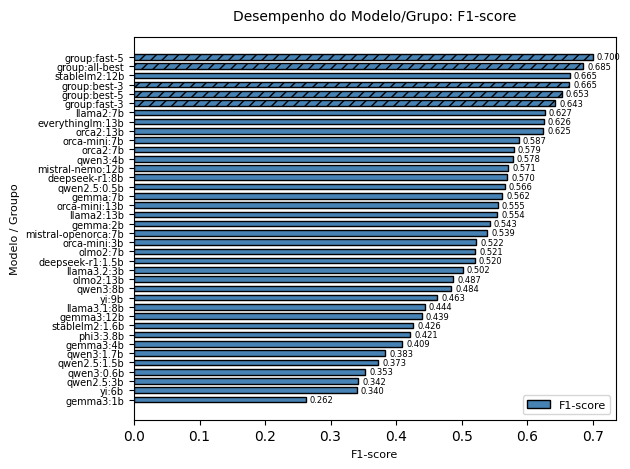

<Figure size 640x480 with 0 Axes>

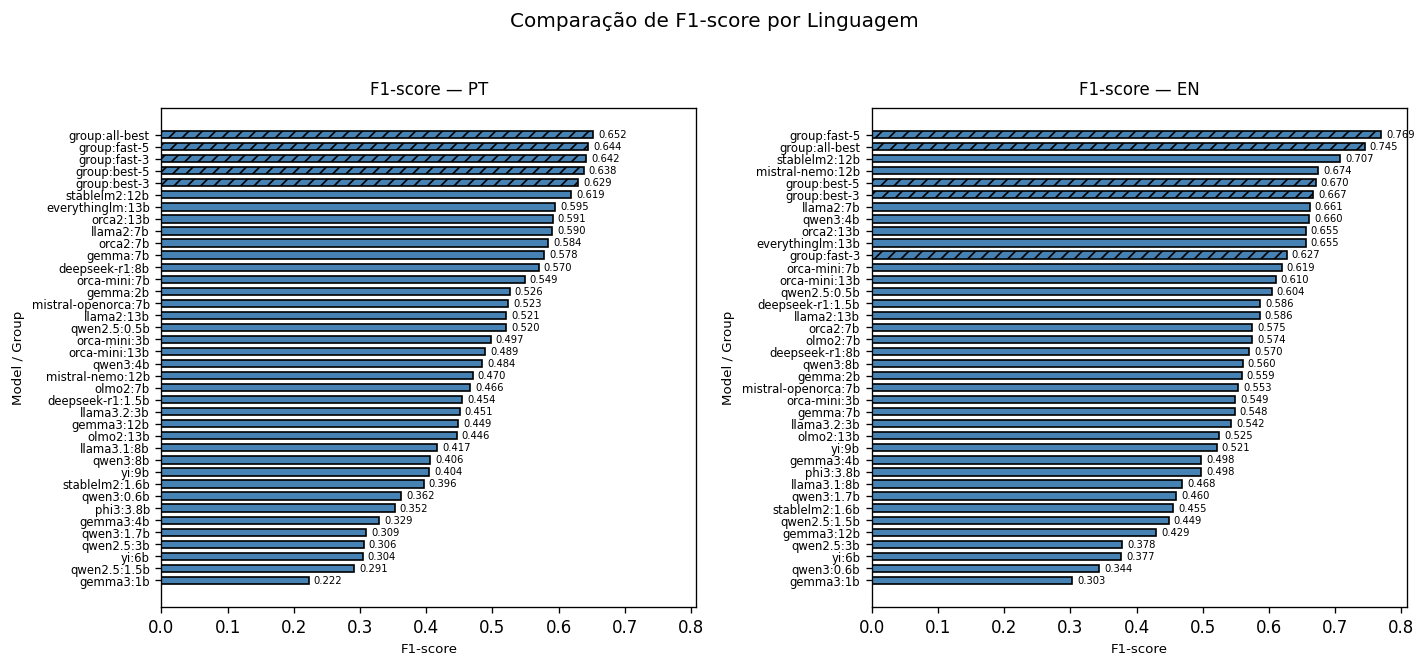

In [100]:
gen_hbar_graph(metrics_df, 'f1_score', 'F1-score')
gen_hbar_lang_graph(metrics_df, 'f1_score', 'F1-score')

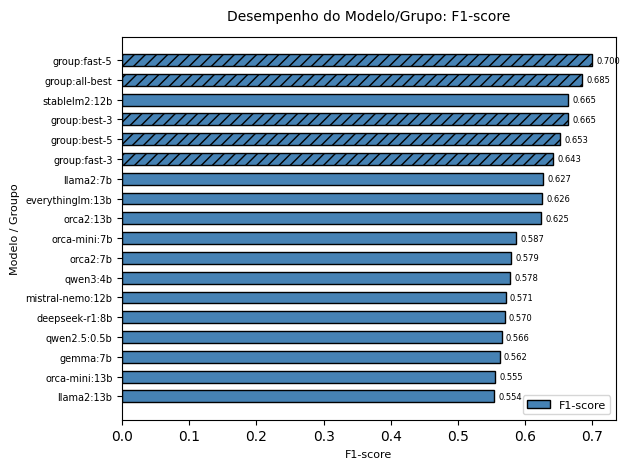

<Figure size 640x480 with 0 Axes>

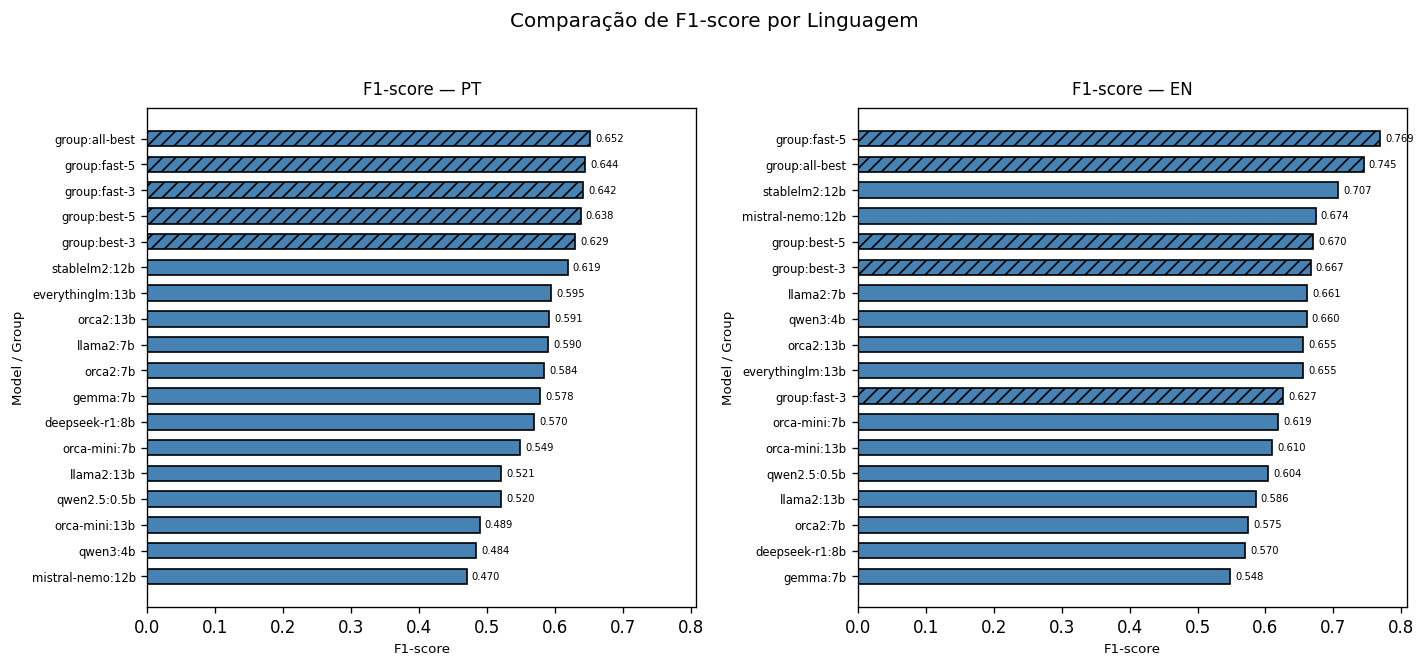

In [101]:
gen_hbar_graph(metrics_df, 'f1_score', 'F1-score', threshold=THRESHOLD)
gen_hbar_lang_graph(metrics_df, 'f1_score', 'F1-score', threshold=THRESHOLD)


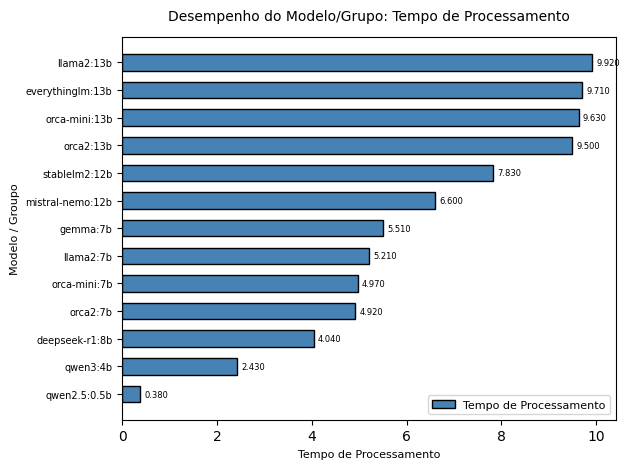

<Figure size 640x480 with 0 Axes>

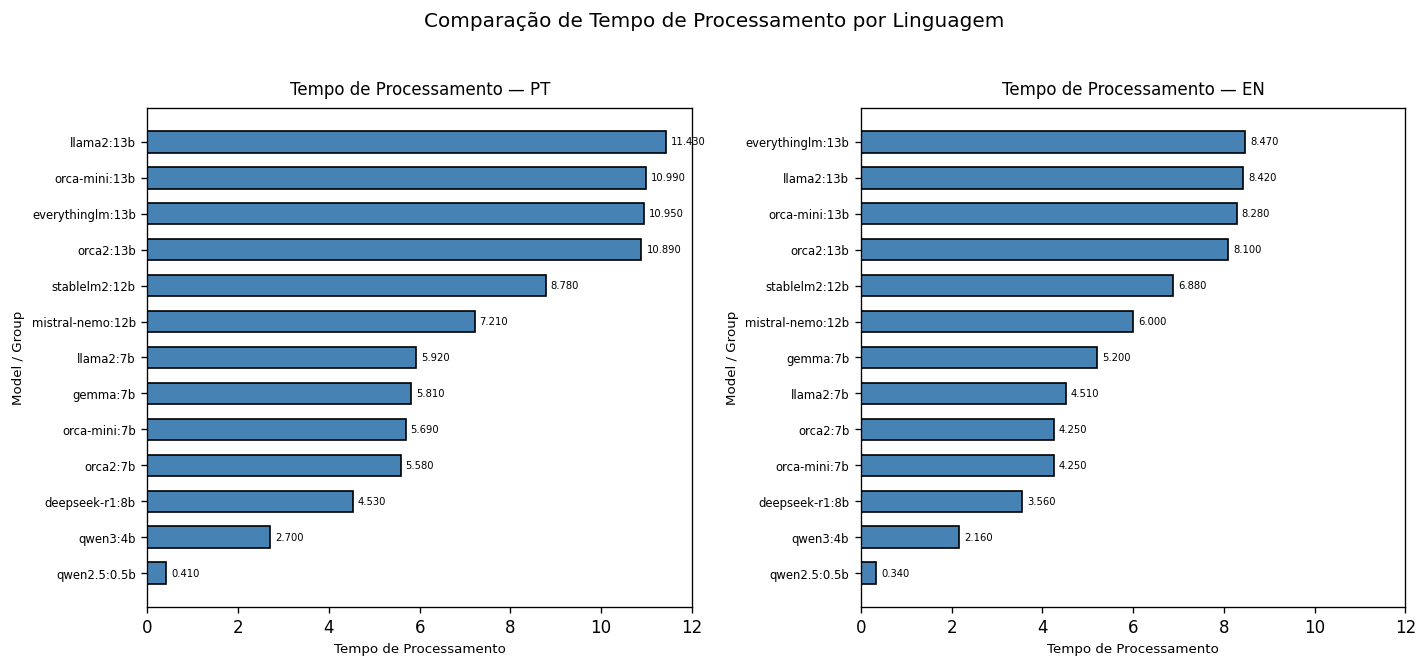

In [102]:
gen_hbar_graph(only_metrics_df, 'avg_processing_time', 'Tempo de Processamento', threshold=THRESHOLD)
gen_hbar_lang_graph(only_metrics_df, 'avg_processing_time', 'Tempo de Processamento', threshold=THRESHOLD)

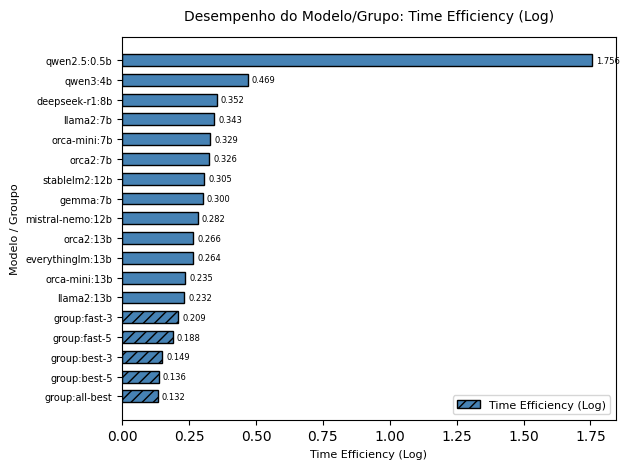

<Figure size 640x480 with 0 Axes>

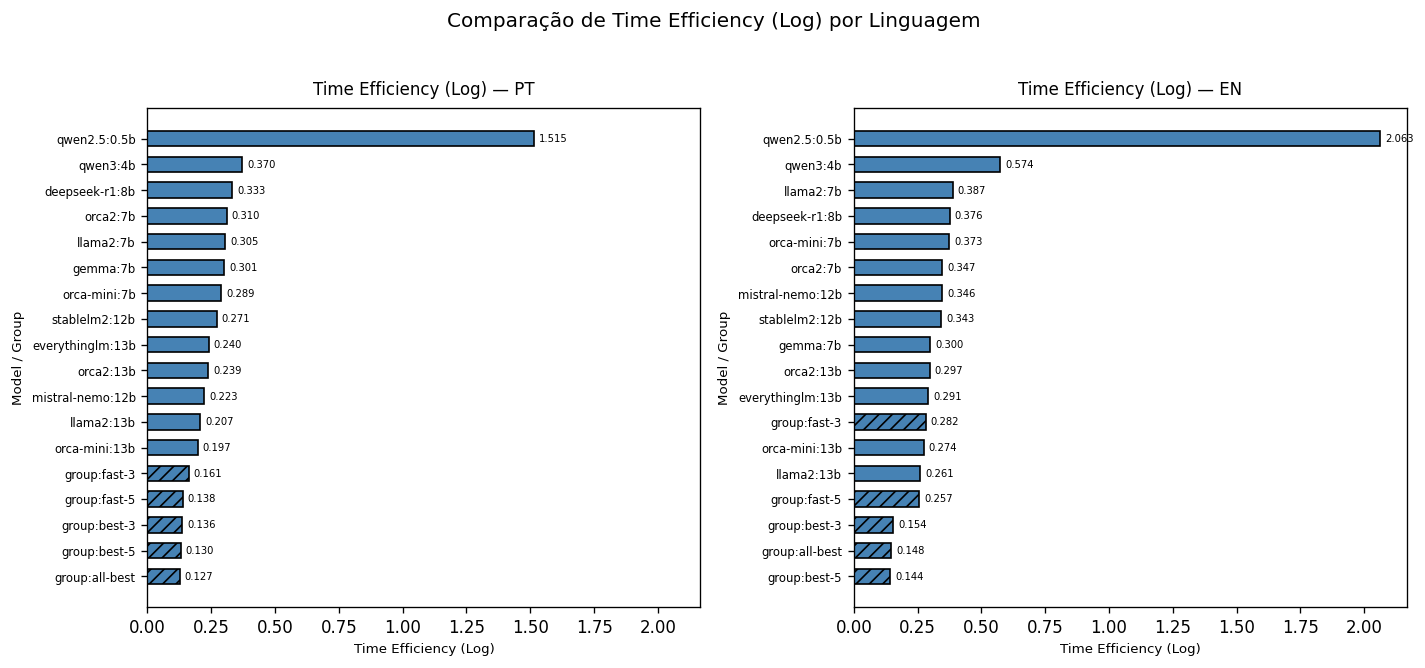

In [103]:
gen_hbar_graph(metrics_df, 'efficiency_log', 'Time Efficiency (Log)', threshold=THRESHOLD)
gen_hbar_lang_graph(metrics_df, 'efficiency_log', 'Time Efficiency (Log)', threshold=THRESHOLD)

In [104]:
# f1_by_rating
ratings = sorted(df['real_rating'].unique())

records = []
for model, grp in df.dropna(subset=['model']).groupby('model'):
    for r in ratings:
        y_true = (grp['real_rating'] == r).astype(int)
        y_pred = (grp['llm_rating'] == r).astype(int)
        records.append({
            'model':       model,
            'real_rating': r,
            'f1_score':    f1_score(y_true, y_pred, zero_division=0)
        })

wide_ratings = df.pivot(index='id', columns='model', values='llm_rating')
manual = df[['id','real_rating']].drop_duplicates('id').set_index('id')

for group_name, modelos in groups.items():
    grp_wide = wide_ratings[modelos]
    group_pred = grp_wide.mode(axis=1)[0].fillna(0).astype(int)
    y_true_full = manual['real_rating']
    for r in ratings:
        y_true = (y_true_full == r).astype(int).loc[group_pred.index]
        y_pred = (group_pred == r).astype(int)
        records.append({
            'model':       f'{group_name}_majority',
            'real_rating': r,
            'f1_score':    f1_score(y_true, y_pred, zero_division=0)
        })

f1_by_rating = (
    pd.DataFrame(records)
      .pivot(index='model', columns='real_rating', values='f1_score')
      .fillna(0)
)

display(f1_by_rating.head())


real_rating,1,2,3,4,5
model,,,,,
all-best_majority,0.228311,0.369620,0.371681,0.143302,0.306569
best-3_majority,0.288210,0.400000,0.373938,0.211957,0.317690
best-5_majority,0.236364,0.397229,0.368775,0.147493,0.264151
deepseek-r1:1.5b,0.280992,0.048544,0.344526,0.359926,0.329268
deepseek-r1:8b,0.413115,0.346154,0.352436,0.128114,0.437500


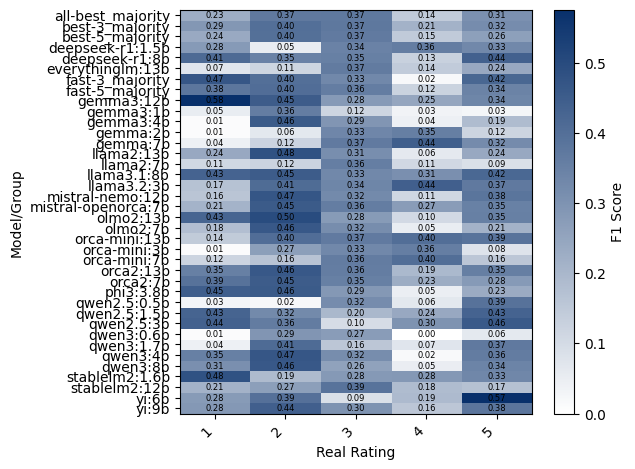

<Figure size 640x480 with 0 Axes>

In [105]:
# f1 by rating heatmap (all)

heatmap_data = f1_by_rating.values
models = f1_by_rating.index.tolist()
ratings = f1_by_rating.columns.tolist()

cmap = LinearSegmentedColormap.from_list(
    'white_to_dark_blue',
    ['#ffffff', '#08306b']
)

vmax = np.nanmax(heatmap_data)

fig, ax = plt.subplots()
im = ax.imshow(
    heatmap_data,
    aspect='auto',
    cmap=cmap,
    vmin=0,
    vmax=vmax
)

ax.set_xticks(np.arange(len(ratings)))
ax.set_xticklabels(ratings)
ax.set_yticks(np.arange(len(models)))
ax.set_yticklabels(models)

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

for i in range(len(models)):
    for j in range(len(ratings)):
        ax.text(
            j, i,
            f"{heatmap_data[i, j]:.2f}",
            ha='center', va='center',
            fontsize=6,
            color='black'
        )

ax.set_xlabel('Real Rating')
ax.set_ylabel('Model/Group')

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('F1 Score')

plt.tight_layout()
plt.show()
plt.savefig('../images/f1-score-heatmap')


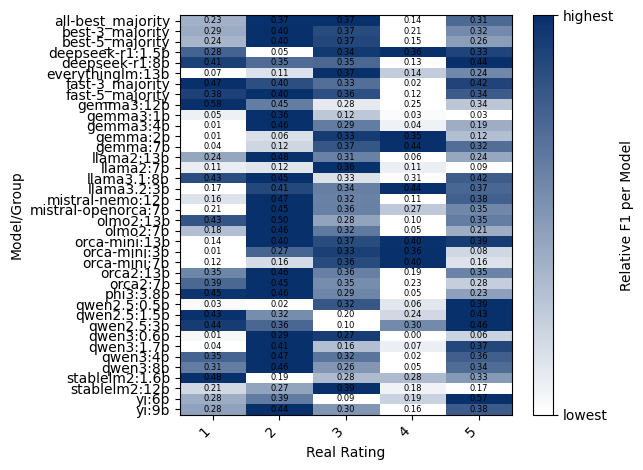

<Figure size 640x480 with 0 Axes>

In [106]:
# f1 by rating heatmap (by model)

data = f1_by_rating.values
models = f1_by_rating.index.tolist()
ratings = f1_by_rating.columns.tolist()

row_min = data.min(axis=1, keepdims=True)
row_max = data.max(axis=1, keepdims=True)
norm_data = (data - row_min) / (row_max - row_min + 1e-9)

cmap = LinearSegmentedColormap.from_list(
    'white_to_dark_blue',
    ['#ffffff', '#08306b']
)

fig, ax = plt.subplots()
im = ax.imshow(norm_data, aspect='auto', cmap=cmap, vmin=0, vmax=1)

ax.set_xticks(np.arange(len(ratings)))
ax.set_xticklabels(ratings)
ax.set_yticks(np.arange(len(models)))
ax.set_yticklabels(models)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

for i in range(len(models)):
    for j in range(len(ratings)):
        ax.text(
            j, i,
            f"{data[i, j]:.2f}",
            ha='center', va='center',
            fontsize=6,
            color='black'
        )

ax.set_xlabel('Real Rating')
ax.set_ylabel('Model/Group')

cbar = fig.colorbar(im, ax=ax, ticks=[0, 1])
cbar.set_ticklabels(['lowest', 'highest'])
cbar.set_label('Relative F1 per Model')

plt.tight_layout()
plt.show()
plt.savefig('../images/f1-score-heatmap-by-model')

In [107]:
def plot_confusion_matrix_with_borders(
    df,
    real_col='real_rating',
    pred_col='manual_prediction',
    labels=None,
    cmap=plt.cm.Blues,
    figsize=(8, 6),
    title='Matriz de Confusão',
    border_cells=(1,2,6,7,8,12,13,14,18,19,20,24,25),
    border_kwargs=None
):
    """
    Gera e plota a matriz de confusão, adiciona borda preta em células específicas
    (contagem da esquerda para a direita, de cima para baixo, 1 a N²) e torna o texto
    de anotação dessas células em negrito.

    Parâmetros:
    - df: DataFrame com as colunas real_col e pred_col
    - real_col: nome da coluna com valores reais
    - pred_col: nome da coluna com predições
    - labels: ordem dos labels a usar (default: inferida)
    - cmap: colormap para o heatmap
    - figsize: tamanho da figura
    - title: título do gráfico
    - border_cells: tupla de índices de célula (1-based) onde desenhar borda
    - border_kwargs: dict com argumentos de estilo para Rectangle (ex: linewidth)
    """
    # Extrai valores
    y_true = df[real_col]
    y_pred = df[pred_col]

    # Define labels
    if labels is None:
        labels = np.unique(np.concatenate([y_true.unique(), y_pred.unique()]))

    # Calcula matriz de confusão
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    n = cm.shape[0]
    cm_sum = cm.sum(axis=1, keepdims=True)
    cm_perc = np.round(cm / cm_sum * 100, 1)

    # Plot principal
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # Configura ticks
    ax.set(
        xticks=np.arange(n),
        yticks=np.arange(n),
        xticklabels=labels,
        yticklabels=labels,
        xlabel='Predição Manual',
        ylabel='Real',
        title=title
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    # Borda padrão
    if border_kwargs is None:
        border_kwargs = dict(edgecolor='black', facecolor='none', linewidth=3)

    # Anotações e bordas
    fmt = '{}\n({:.1f}%)'
    thresh = cm.max() / 2
    for i in range(n):
        for j in range(n):
            count = cm[i, j]
            perc = cm_perc[i, j]
            cell_num = i * n + j + 1

            # Define estilo de fonte: negrito se estiver na lista de border_cells
            text_kwargs = dict(
                ha='center', va='center',
                color='white' if count > thresh else 'black',
                fontsize=10,
                fontweight='bold' if cell_num in border_cells else 'normal'
            )
            ax.text(j, i, fmt.format(count, perc), **text_kwargs)

            # Desenha borda se necessário
            if cell_num in border_cells:
                ax.add_patch(
                    Rectangle((j - 0.5, i - 0.5), 1, 1, **border_kwargs)
                )

    plt.tight_layout()
    plt.show()
    return fig, ax

def plot_confusion_matrix_by_language(
    df,
    real_col='real_rating',
    pred_col='manual_prediction',
    lang_col='language',
    labels=None,
    cmap=plt.cm.Blues,
    figsize=(18, 6),
    titles=('Todos', 'PT', 'EN'),
    border_cells=(1,2,6,7,8,12,13,14,18,19,20,24,25),
    border_kwargs=None
):
    """
    Plota três matrizes de confusão lado a lado:
      1) com todos os dados,
      2) apenas dados em português (lang_col == 'pt'),
      3) apenas dados em inglês (lang_col == 'en').

    Parâmetros:
    - df: pandas.DataFrame com as colunas real_col, pred_col e lang_col
    - real_col: nome da coluna de rótulos reais
    - pred_col: nome da coluna de predições
    - lang_col: nome da coluna de linguagem (com valores 'pt' e 'en')
    - labels: lista de rótulos na ordem desejada (default: inferida)
    - cmap: colormap para os heatmaps
    - figsize: tupla (width, height) para o tamanho da figura
    - titles: tupla de títulos para cada subplot (total, pt, en)
    - border_cells: índices 1-based das células a receber borda e texto em negrito
    - border_kwargs: dict de estilo para Rectangle (edgecolor, linewidth, etc.)
    """
    # Default style for borders
    if border_kwargs is None:
        border_kwargs = dict(edgecolor='black', facecolor='none', linewidth=3)

    # Prepare y_true and y_pred for all data to infer labels if needed
    y_true_all = df[real_col]
    y_pred_all = df[pred_col]
    if labels is None:
        labels = np.unique(np.concatenate([y_true_all.unique(), y_pred_all.unique()]))

    # Prepare subsets
    subsets = [
        (titles[0], df),
        (titles[1], df[df[lang_col] == 'pt']),
        (titles[2], df[df[lang_col] == 'en']),
    ]

    n_labels = len(labels)
    fig, axes = plt.subplots(ncols=3, figsize=figsize, dpi=120, sharey=True)
    
    for ax, (title, subdf) in zip(axes, subsets):
        # Compute confusion matrix
        y_true = subdf[real_col]
        y_pred = subdf[pred_col]
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        cm_sum = cm.sum(axis=1, keepdims=True)
        cm_perc = np.round(cm / cm_sum * 100, 1)

        # Plot heatmap
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax)

        # Configure ticks and labels
        ax.set(
            xticks=np.arange(n_labels),
            yticks=np.arange(n_labels),
            xticklabels=labels,
            yticklabels=labels,
            xlabel='Predição Manual',
            ylabel='Real' if title == titles[0] else '',
            title=title
        )
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

        # Annotate cells and draw borders
        thresh_abs = cm.max() / 2
        for i in range(n_labels):
            for j in range(n_labels):
                cell_idx = i * n_labels + j + 1
                count = cm[i, j]
                pct = cm_perc[i, j]
                text = f"{count}\n({pct:.1f}%)"
                weight = 'bold' if cell_idx in border_cells else 'normal'
                color_txt = 'white' if cm[i, j] > thresh_abs else 'black'
                ax.text(
                    j, i, text,
                    ha='center', va='center',
                    fontsize=10, fontweight=weight,
                    color=color_txt
                )
                if cell_idx in border_cells:
                    ax.add_patch(Rectangle((j-0.5, i-0.5), 1, 1, **border_kwargs))

    plt.tight_layout()
    plt.show()
    return fig, axes

In [108]:
plot_confusion_matrix_with_borders(metrics_df)

KeyError: 'real_rating'